In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# defining the Dataframe
df = pd.read_csv('/kaggle/input/zomato-delivery-operations-analytics-dataset/Zomato Dataset.csv')
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


# **Preprocessing/Data Cleaning/EDA***

In [3]:
# Lowering all the columns so there is no typo while mentioning column names
df.columns = [col.lower() for col in df.columns]
df.rename(columns = {'time_taken (min)' : 'time_taken_min'}, inplace = True)

In [4]:
# Droping all null values as they all are less than 1%
df.dropna(inplace = True)

In [5]:
# Removing duplicates rows
duplicates = df[df.duplicated(subset=['delivery_person_id', 'order_date', 'time_orderd'])]
df.drop_duplicates(subset = ['delivery_person_id', 'order_date', 'time_orderd'], inplace=True)

In [6]:
# Extractin month from the order date column
df['Order_month'] = pd.DatetimeIndex(df['order_date']).month

In [7]:
# Both the columns 'time_orderd' and 'time_order_picked' are time type but not in correct format so first removing format which are incorrect
valid_format = df['time_orderd'].str.match(r'\d{1,2}:\d{2}')
df['time_orderd'] = df['time_orderd'][valid_format]

valid_format1 = df['time_order_picked'].str.match(r'(0[0-9]|1[0-9]|2[0-3]):[0-5][0-9]')
df['time_order_picked'] = df['time_order_picked'][valid_format1]


In [8]:
# Now converting time_orderd and time_order_picked into time type
df['time_orderd'] = pd.to_datetime(df['time_orderd'], format = '%H:%M')

df['time_order_picked'] = pd.to_datetime(df['time_order_picked'], format = '%H:%M')

In [9]:
# Making a new column 'pickup_time' in mintues unit to show the total time between time orderd and time_order_picked
df['pickup_time'] = df['time_order_picked']  - df['time_orderd'] 
df['pickup_time'] = df['pickup_time'].dt.total_seconds()/60

In [10]:
# 1% null values coming in df['pickup_time'] column so dropping them.
df['pickup_time'].isnull().sum()/df.size*100
df.dropna(inplace= True)

<Axes: xlabel='multiple_deliveries'>

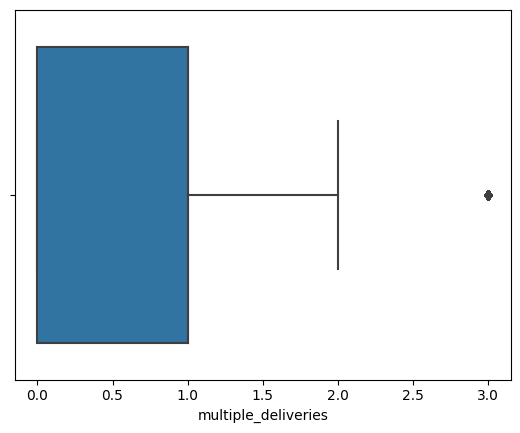

In [11]:
# Checking for outliers for each column:
sns.boxplot(x = 'multiple_deliveries', data = df)

In [12]:
# Multiple_deliveries shows some outliers in the boxplot. replacing outliers with mode
replace_mode = int(df['multiple_deliveries'].mode())
df['multiple_deliveries'] = df['multiple_deliveries'].apply(lambda x: replace_mode if x == 3 else x)

In [13]:
# Using HAVERSINE function to calculate the distance between 2 geolocations
import haversine as hs
from haversine import Unit
restaurant_loc = [i for i in zip(df['restaurant_latitude'], df['restaurant_longitude'])]
delivery_loc = [i for i in zip(df['delivery_location_latitude'], df['delivery_location_longitude'])]

In [14]:
# Creating a new column which has total distance covered by the delivery person based  on longitude and latitude of restaurant and delivery address
df['total_distance'] = [hs.haversine(loc1, loc2, unit = Unit.METERS) for loc1, loc2 in zip(restaurant_loc, delivery_loc)]


In [15]:
# Dropping rows which are of no signifance
df.drop(['id', 'delivery_person_id', 'restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 
          'delivery_location_longitude', 'time_orderd', 'time_order_picked', 'type_of_order', 'type_of_vehicle', 
         'order_date'], axis =1, inplace = True)

In [16]:
# Feature encoding on categorical columns
one_hot_col = ['weather_conditions', 'festival', 'city']
label_en_col = ['road_traffic_density', ]

In [17]:
# One-hot-encoding
df = pd.get_dummies(df, columns = one_hot_col, drop_first = True)

In [18]:
# Transforming road_traffic_density to labels
def label_encod(x):
    if x == 'Jam':
        return 4
    elif x == 'High':
        return 3
    elif x == 'Medium':
        return 2
    else:
        return 1

df['road_traffic_density'] = df['road_traffic_density'].apply(label_encod)   

<Axes: >

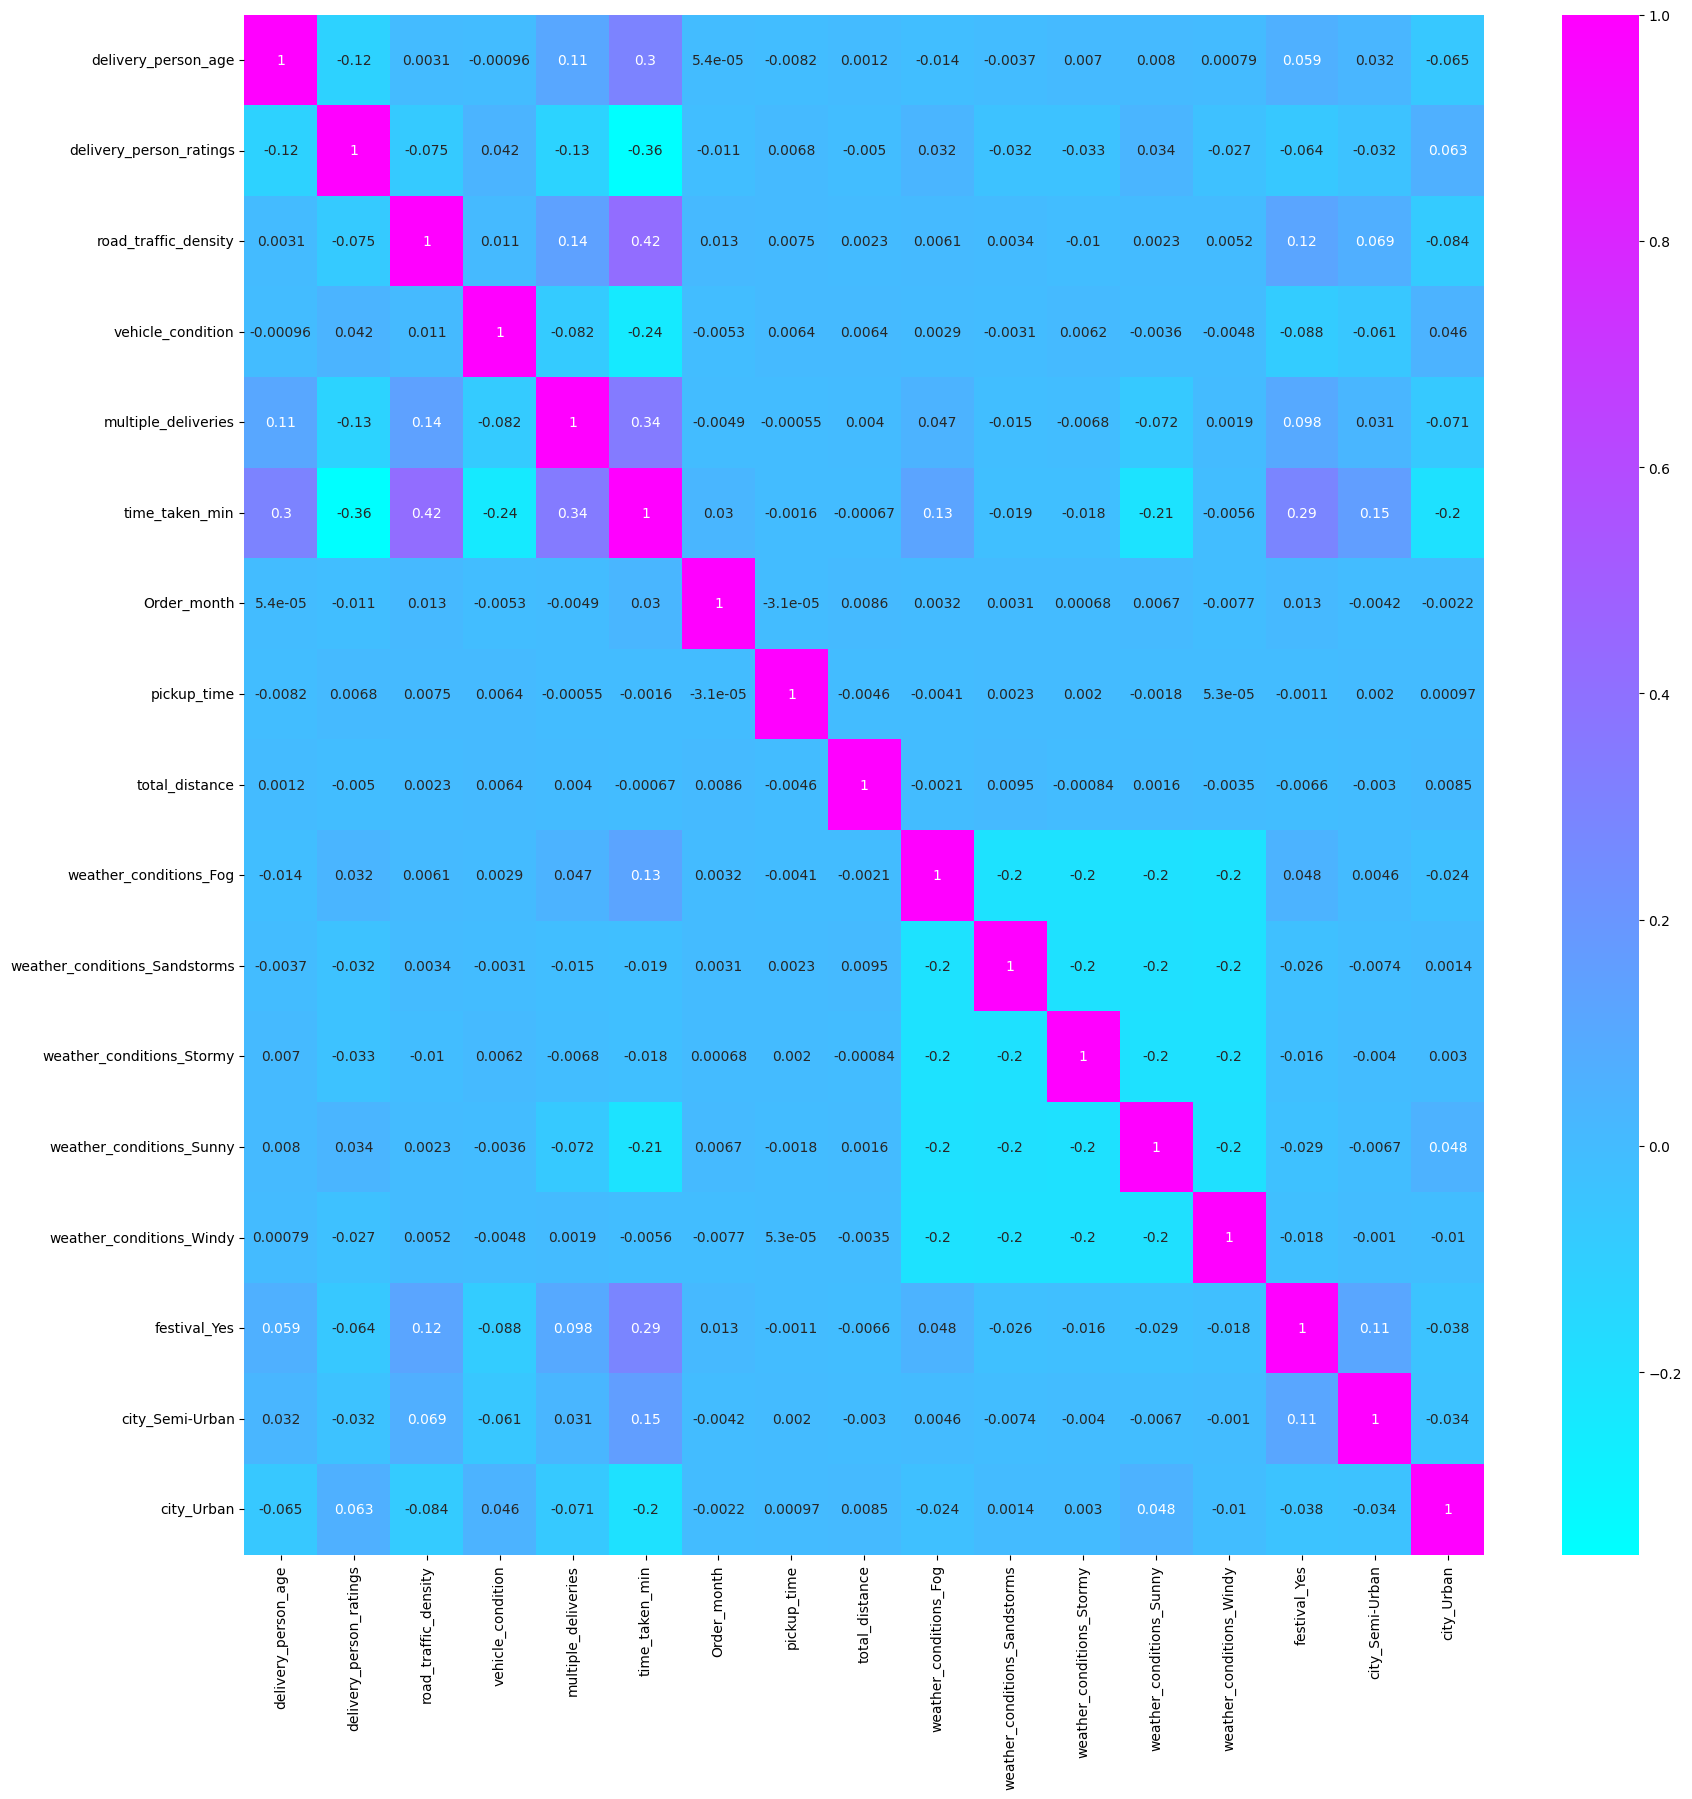

In [19]:
# Using heatmap to view correlation
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), cmap = 'cool', annot = True)


# **Spilitting data into train and test**

In [20]:
# Seperating indipendent variables and target variable
X = df.drop(['time_taken_min'], axis=1)
Y = df['time_taken_min']

In [21]:
# Feature scalining on X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled= scaler.fit_transform(X)

In [22]:
#split the data into training and test 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y, test_size =0.20, random_state = 42)

# ****Choosing the Best Model using Lazypredict

In [24]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(predictions = True)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

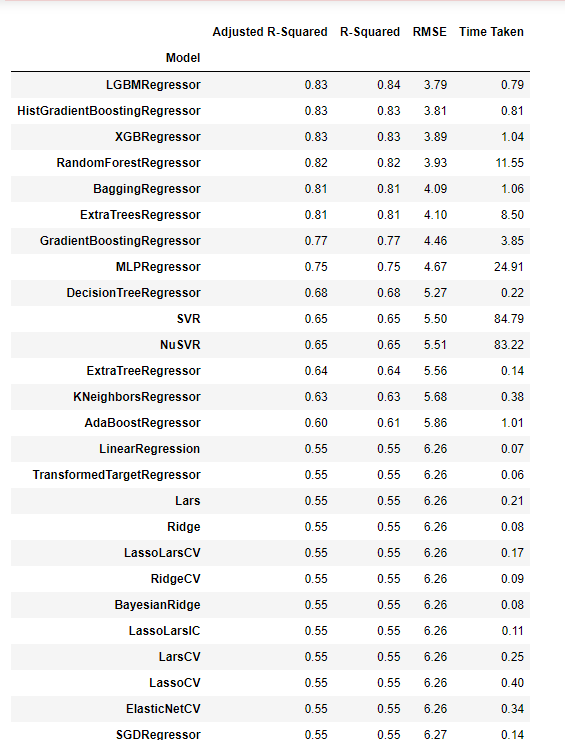


# ****Model 1: LGBM Regressor

In [25]:
# Implementing LGBM Regressor Model
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(metric = 'rmse')
model_lgbm.fit(x_train, y_train)

y_train_predict = model_lgbm.predict(x_train)
y_test_predict = model_lgbm.predict(x_test)

training_rmse = np.sqrt(mse(y_train_predict, y_train))
test_rmse = np.sqrt(mse(y_test_predict, y_test))

print(training_rmse)
print(test_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 26652, number of used features: 16
[LightGBM] [Info] Start training from score 26.566899
3.676119861167438
3.863494249463953


In [26]:
# Measuring R2 for LGBM Regressor
from sklearn.metrics import r2_score
print('training R2 score :', r2_score(y_train_predict, y_train))
print('testing R2 score: ', r2_score(y_test_predict, y_test))

training R2 score : 0.8071362146125145
testing R2 score:  0.7914700163312469


# ****Model 2: RandomForest

In [27]:
# Implementing Random Forest
from sklearn.ensemble import RandomForestRegressor
#for max_depth > 13, the model is overfitting so we'll take max_depth = 13 to control overfitting.
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=13)
rf.fit(x_train, y_train)

y_train_predict = rf.predict(x_train)
y_test_predict = rf.predict(x_test)

training_rmse_rf = np.sqrt(mse(y_train_predict, y_train))
test_rmse_rf = np.sqrt(mse(y_test_predict, y_test))

print(training_rmse_rf)
print(test_rmse_rf)

3.0766429610688455
3.900606214373194


In [28]:
# Measuring R2 for RandomForest
from sklearn.metrics import r2_score
print('training R2 score for RF:', r2_score(y_train_predict, y_train))
print('testing R2 score for RF: ', r2_score(y_test_predict, y_test))

training R2 score for RF: 0.8715611995300052
testing R2 score for RF:  0.7960005311268361


**Random Forest is giving us better results with Hyperparameter tuning**

In [29]:
import pickle
zomato_model = pickle.dumps(rf)